# Практическое задание по занятию Denosing Diffusional Models

ФИО: Филимонов Степан Владиславович

## Задание

0) Скачайте репозиторий git clone https://github.com/awjuliani/pytorch-diffusion.git

1) Обучите модель для датасета Fasion MNIST. Продемонстрируйте обратный диффузионный процесс с нескольких random seeds (1 балл)

2) Добавьте к обучению DDPM условие на метку с помощью Classifier Free Guidance https://arxiv.org/abs/2207.12598. (2 балла)

3) Обучите модель в режиме inpainting. Параграф 4.1 в https://arxiv.org/pdf/2201.09865.pdf . (1 балл)


## Решение

0) Скачайте репозиторий git clone https://github.com/awjuliani/pytorch-diffusion.git

In [ ]:
!git clone git@github.com:awjuliani/pytorch-diffusion.git
!mkdir source
!mv pytorch-diffusion/* source/
!rm -rf pytorch-diffusion/
!rm source/.git*
!sed -i '' 's| modules | source.modules |' source/model.py

1) Обучите модель для датасета Fasion MNIST. Продемонстрируйте обратный диффузионный процесс с нескольких random seeds (1 балл)

In [1]:
from source.data import DiffSet
from source.model import DiffusionModel

import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from torch.utils.data import DataLoader
import imageio
import glob

In [2]:
diffusion_steps = 1000
dataset_choice = "Fashion"
max_epoch = 10
batch_size = 128
load_model = False
load_version_num = 1

In [3]:
pass_version = None
last_checkpoint = None

if load_model:
    pass_version = load_version_num
    last_checkpoint = glob.glob(
        f"./lightning_logs/{dataset_choice}/version_{load_version_num}/checkpoints/*.ckpt"
    )[-1]

In [4]:
train_dataset = DiffSet(True, dataset_choice)
val_dataset = DiffSet(False, dataset_choice)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26.4M/26.4M [00:03<00:00, 8.44MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29.5k/29.5k [00:00<00:00, 677kB/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.42M/4.42M [00:00<00:00, 6.37MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.15k/5.15k [00:00<00:00, 28.1MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [5]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4, shuffle=True)

In [6]:
model = DiffusionModel.load_from_checkpoint(
        last_checkpoint,
        in_size=train_dataset.size*train_dataset.size,
        t_range=diffusion_steps,
        img_depth=train_dataset.depth
    ) if load_model else DiffusionModel(
        train_dataset.size*train_dataset.size,
        diffusion_steps,
        train_dataset.depth
    )

In [7]:
tb_logger = pl.loggers.TensorBoardLogger(
    "lightning_logs/",
    name=dataset_choice,
    version=pass_version,
)

trainer = pl.Trainer(
    max_epochs=max_epoch,
    accelerator="auto"
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [8]:
trainer.fit(model, train_loader, val_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 4060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name  | Type       | Params | Mode 
----------------------------------------------
0  | inc   | DoubleConv | 37.7 K | train
1  | down1 | Down       | 295 K  | train
2  | down2 | Down       | 1.2 M  | train
3  | down3 | Down       | 2.4 M  | train
4  | up1   | Up         | 6.2 M  | train
5  | up2   | Up         | 1.5 M  | train
6  | up3   | Up         | 406 K  | train
7  | outc  | OutConv    | 65     | train
8  | sa1   | SAWrapper  | 395 K  | train
9  | sa2   | SAWrapper  | 395 K  | train
10 | sa3   | SAWrapper  | 99.6 K | train
----------------------------------------------
12.9

Sanity Checking: |                                                                                            …

/home/stepan/jupyter-venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=10` reached.


In [9]:
def generate():
    gif_shape = [3, 3]
    sample_batch_size = gif_shape[0] * gif_shape[1]
    n_hold_final = 10

    gen_samples = []
    x = torch.randn((sample_batch_size, train_dataset.depth, train_dataset.size, train_dataset.size))
    sample_steps = torch.arange(model.t_range-1, 0, -1)
    for t in sample_steps:
        x = model.denoise_sample(x, t)
        if t % 50 == 0:
            gen_samples.append(x)
    for _ in range(n_hold_final):
        gen_samples.append(x)
    gen_samples = torch.stack(gen_samples, dim=0).moveaxis(2, 4).squeeze(-1)
    gen_samples = (gen_samples.clamp(-1, 1) + 1) / 2

    gen_samples = (gen_samples * 255).type(torch.uint8)
    gen_samples = gen_samples.reshape(-1, gif_shape[0], gif_shape[1], train_dataset.size, train_dataset.size, train_dataset.depth)

    def stack_samples(gen_samples, stack_dim):
        gen_samples = list(torch.split(gen_samples, 1, dim=1))
        for i in range(len(gen_samples)):
            gen_samples[i] = gen_samples[i].squeeze(1)
        return torch.cat(gen_samples, dim=stack_dim)

    gen_samples = stack_samples(gen_samples, 2)
    return stack_samples(gen_samples, 2)

In [10]:
def plot(imgs):
    assert len(imgs) == 29
    plt.figure(figsize=(10, 10), dpi=600)
    for i in range(30):
        if i < len(imgs):
            plt.subplot(5, 6, i + 1)
            plt.imshow(imgs[i].detach().numpy(), cmap=plt.cm.Greys_r)
            plt.axis('off')

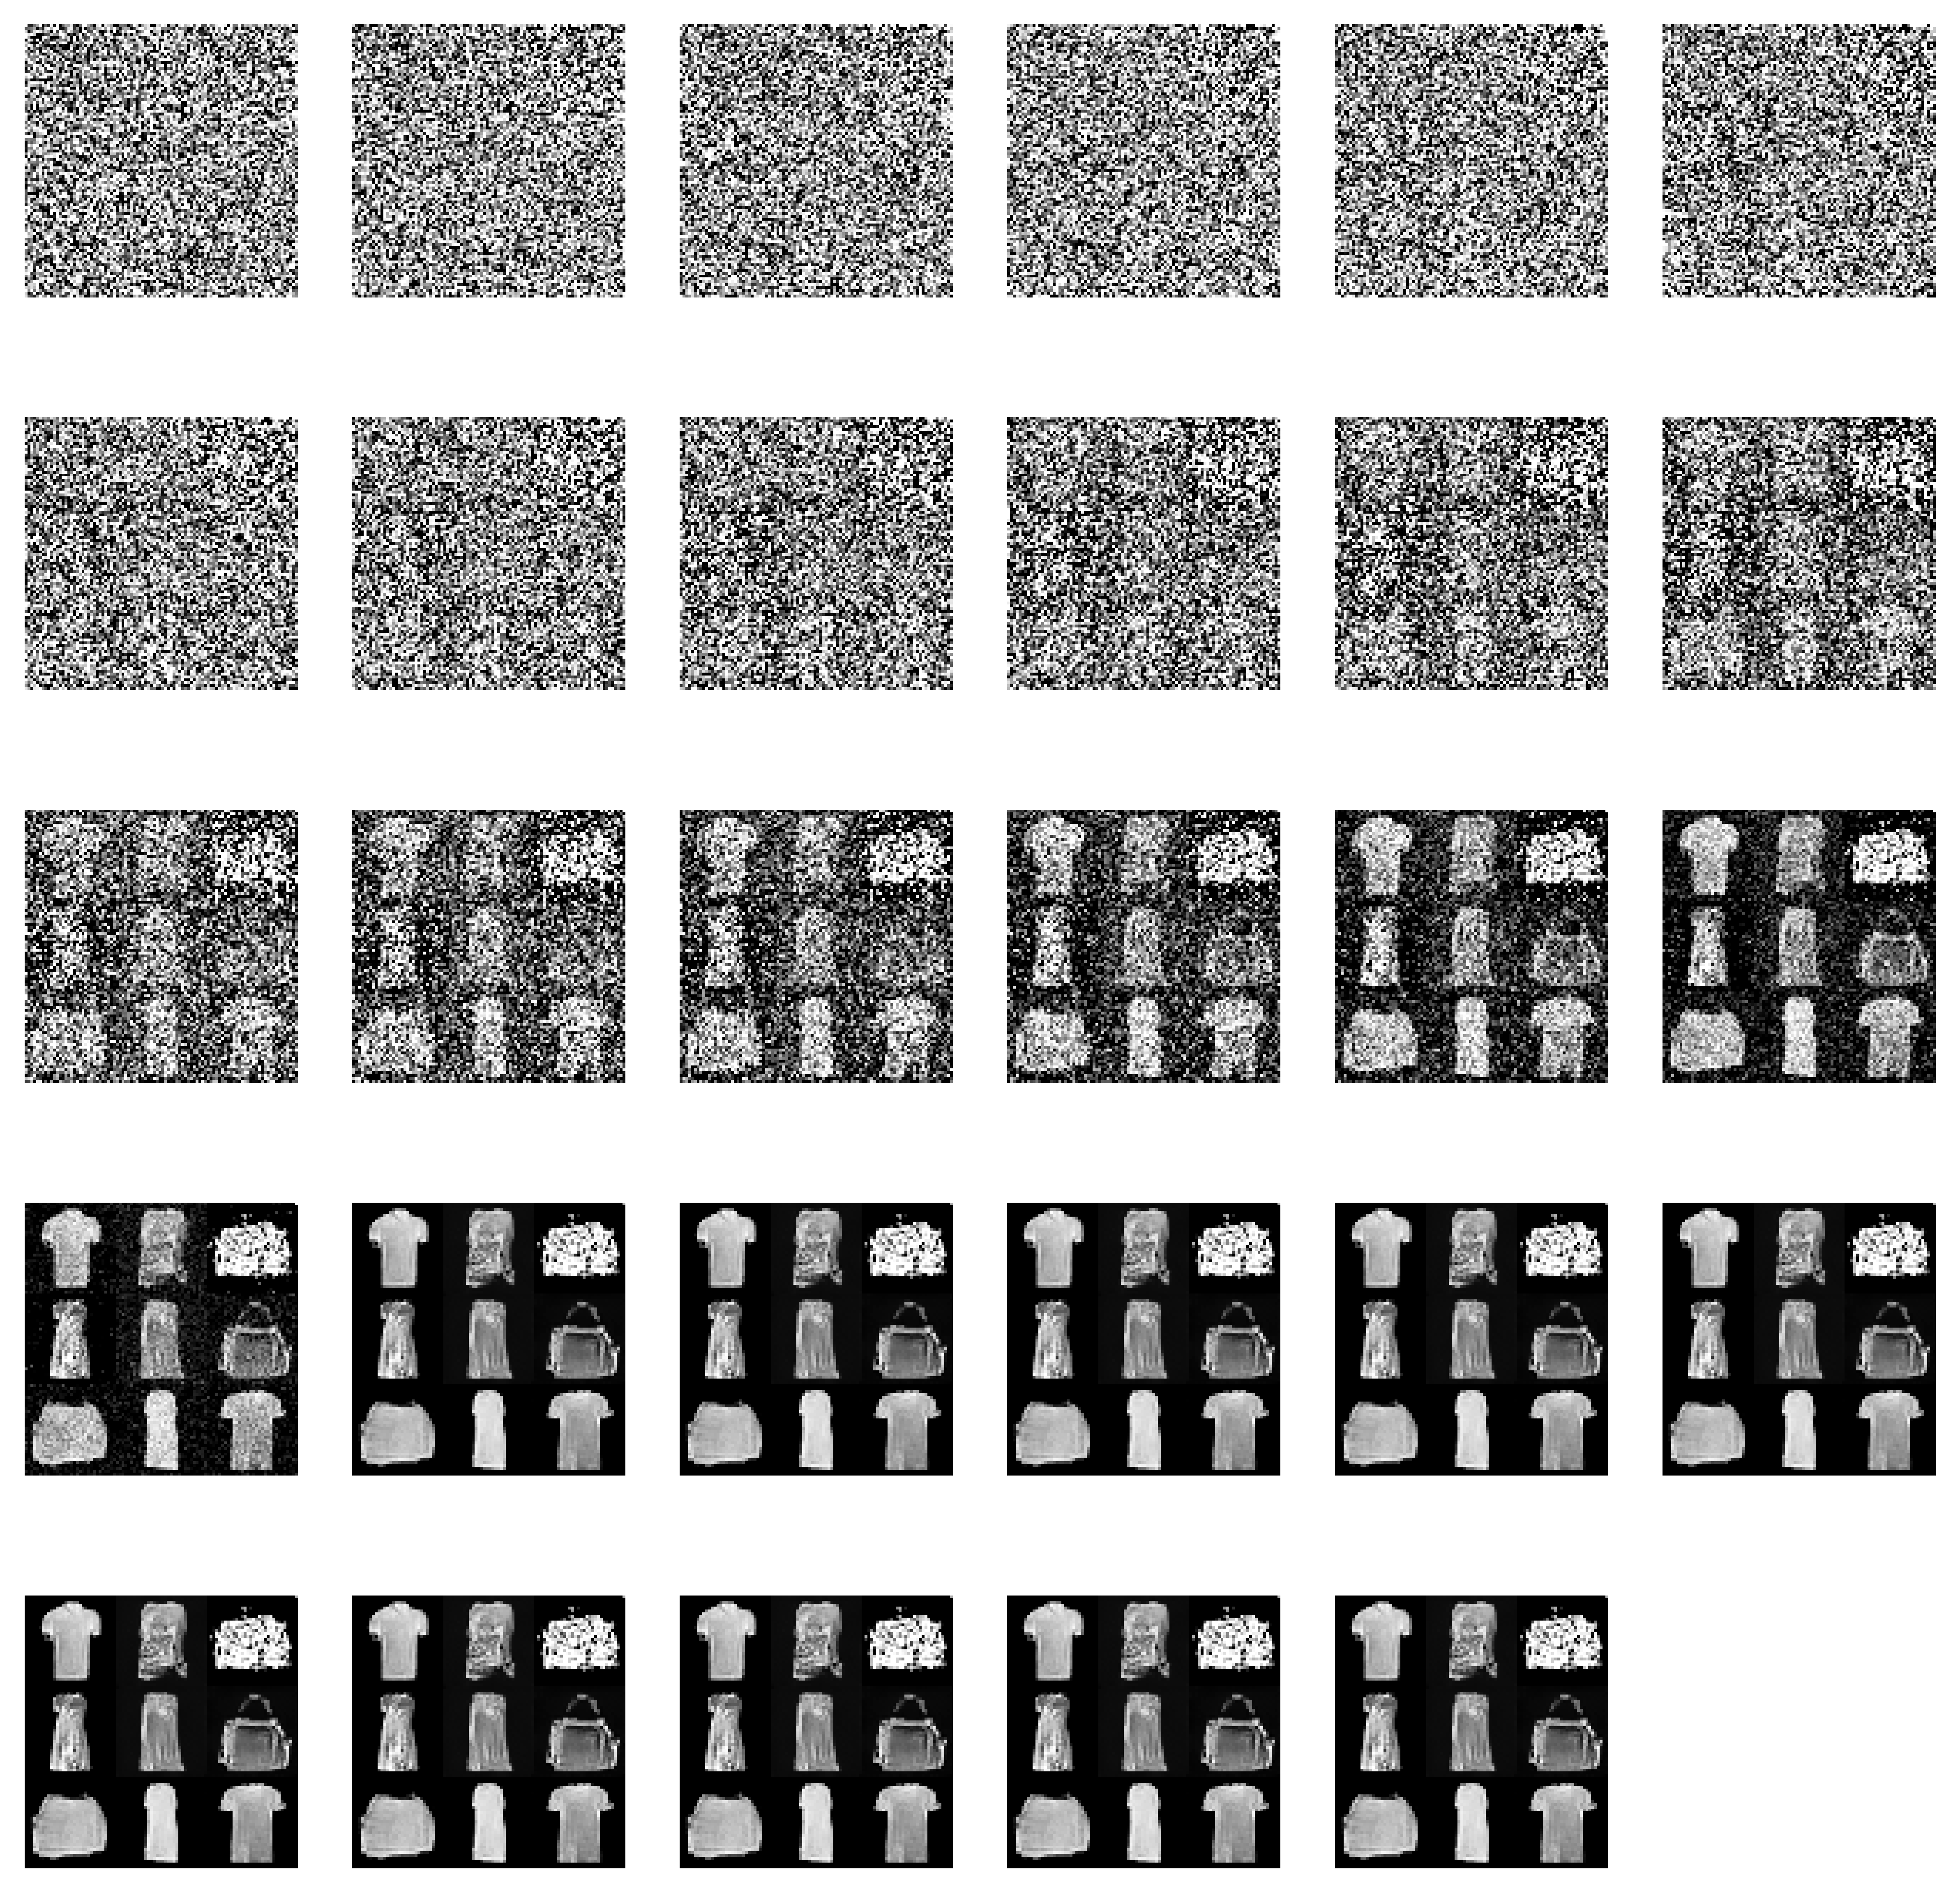

In [11]:
plot(generate())

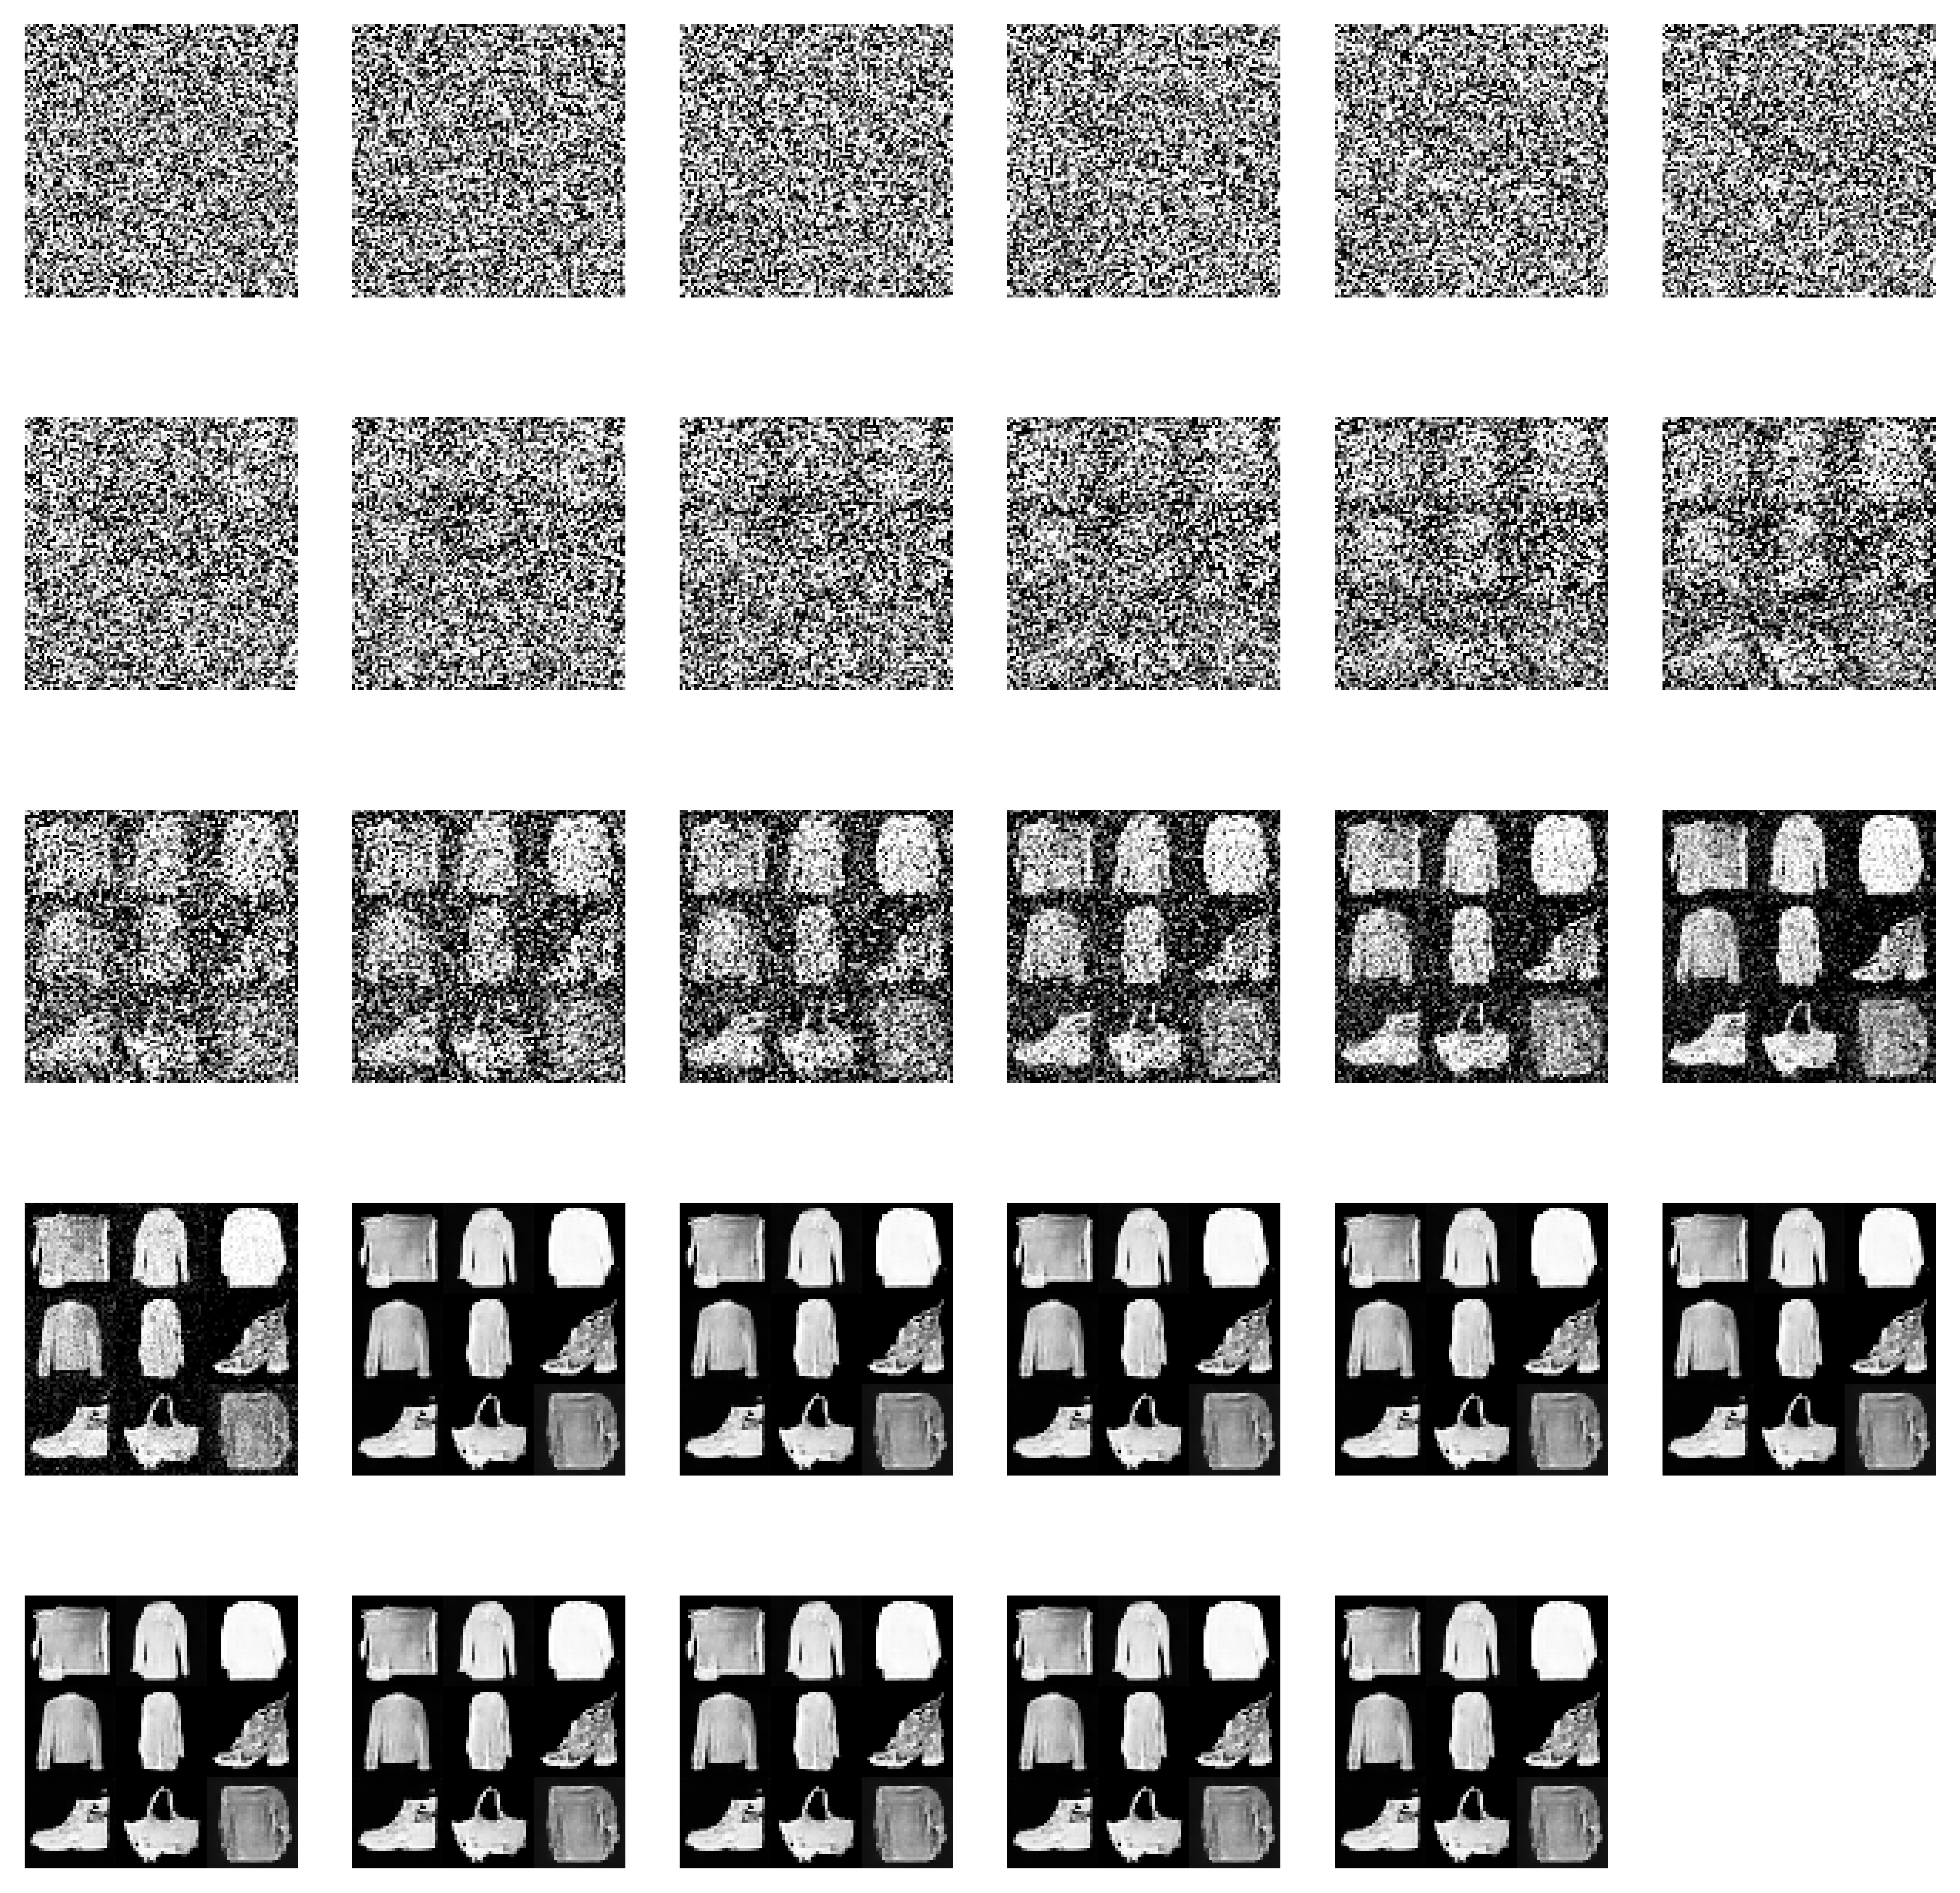

In [12]:
plot(generate())

По результату видно, что повторений нету

**Вывод:**

1) Успел только первый номер как-то осмыслить, на остальные времени не хватало